# <center> K-NN for California Housing </center>

&copy; 2023 Kaiwen Zhou

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Load Data

In [2]:
import os
import tarfile  # Read and write tar archive files
from six.moves import urllib  # compatible with both Python 2 and Python 3

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Download data and put it in the right place
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
        
    tgz_path = os.path.join(housing_path, "housing.tgz")
    if not os.path.isfile(tgz_path): # download data if not already there
        urllib.request.urlretrieve(housing_url, tgz_path)
        
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

# Import Data

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    """
    From .tgz ---> csv
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

# Check Attributes

In [5]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
# Note that there is a mixture of floats and categorical features
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


# Analyze the ocean_proximity feature

In [7]:
# These are the categorical features
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

<AxesSubplot:>

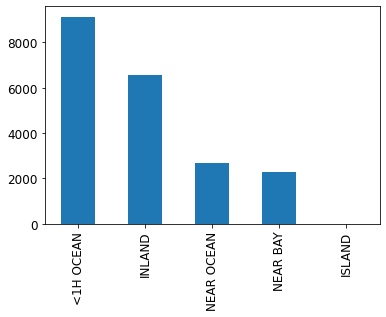

In [8]:
housing["ocean_proximity"].value_counts().plot.bar()

**We can see from the bar chart above that the ocean_proximity distribution is very skewed.**

**If we use random selection, the train_set or the test_set or both might be biased. Then, we will train our model on a biased dataset which will eventually produce a biased result.**

**Hence, we have to stratify our data against the distribution of the ocean_proximity feature to make the train_set and the test_test proportional to the overall sample dataset.**

# Train-Test Split with Stratify

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=30)
for train_index, test_index in split.split(housing, housing["ocean_proximity"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
housing["ocean_proximity"].value_counts() / len(housing)

<1H OCEAN     0.442636
INLAND        0.317393
NEAR OCEAN    0.128779
NEAR BAY      0.110950
ISLAND        0.000242
Name: ocean_proximity, dtype: float64

In [11]:
# Let's verify....

# Overall Distribution for ocean_proximity
def income_cat_proportions(data):
    return data["ocean_proximity"].value_counts() / len(data)

# Ordinary train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=30)

# Calculate the Overall Distribution, the Stratified Split Distribution
# and the Random (Ordinary) Split Distribution
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

Let's compare!

In [12]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
<1H OCEAN,0.442636,0.442587,0.448401,1.302539,-1.094571e-02
INLAND,0.317393,0.317345,0.315407,-0.625859,-1.526485e-02
ISLAND,0.000242,0.000242,NaN,NaN,1.421085e-14
NEAR BAY,0.110950,0.110950,0.110950,0.000000,0.000000e+00
NEAR OCEAN,0.128779,0.128876,0.125242,-2.746426,7.524454e-02


# Prepare the data for Machine Learning algorithms

# Check our train_set

In [13]:
housing = strat_train_set

In [14]:
housing.shape

(16512, 10)

In [15]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
13291,-117.66,34.07,33.0,2081.0,409.0,1008.0,375.0,2.5870,138100.0,INLAND
12668,-121.44,38.48,12.0,4929.0,1010.0,2621.0,870.0,2.7262,109800.0,INLAND
3753,-118.39,34.17,40.0,1696.0,372.0,835.0,385.0,3.6563,222400.0,<1H OCEAN
7727,-118.12,33.93,27.0,580.0,143.0,466.0,133.0,3.0909,187500.0,<1H OCEAN
14903,-117.07,32.60,13.0,1607.0,435.0,983.0,400.0,2.2903,106300.0,NEAR OCEAN


## Construct DataFrameSelector to select numerical or categorical columns

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

## Construct PipelineFriendlyLabelBinarizer to encode the categorical columns

In [17]:
from sklearn.preprocessing import LabelBinarizer 
class PipelineFriendlyLabelBinarizer(LabelBinarizer):
    def fit_transform(self, X, y=None):
        return super(PipelineFriendlyLabelBinarizer, self).fit_transform(X)

## Import SimpleImputer to deal with missing values (NaN) in the dataset

In [18]:
from sklearn.impute import SimpleImputer

## Construct pipeline for both the numerical data and the categorical data

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# let's now combine the numerical and categorical pipelines
num_attribs = list(housing)[:-1]  # all numerical features (i.e. no ocean_proximity)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        # select the numerical columns
        ('selector', DataFrameSelector(num_attribs)),  
        # replace NaN values with median of the corresponding column
        ('imputer', SimpleImputer(strategy="median")), 
        # rescale the magnitude of each value so that they are around 0, then our calculation won't explode (run-off error)
        ('std_scaler', StandardScaler())               
    ])

cat_pipeline = Pipeline([
        # select the categorical columns
        ('selector', DataFrameSelector(cat_attribs)),
        # encode categorical labels, so they are easier to deal with
        ('label_encoder', PipelineFriendlyLabelBinarizer()),
    ])

## Aggregate both pipeline

In [21]:
# and concatenate them with FeatureUnion class
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Apply pipeline on the train_set with stratification to make the transform

In [22]:
# this is the final transformation result!
housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared.shape

(16512, 14)

This is correct. A matrix containing input $\mathbb{R}^{N\times 9}$ ($9$ different features) and label $\mathbb{R}^{N\times 5}$ (5 categories/classes) is exactly what we needed.

## Separate train_set input (X) and train_set label (Y)

In [23]:
housing_input = housing_prepared[:,0:9]
housing_label = housing_prepared[:,9:14]

Sanity Check:

In [24]:
housing_label

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.]])

# Test set:Separate test_set input (X) and test_set label (Y)

In [25]:
housing_test = strat_test_set
housing_test_prepared = full_pipeline.fit_transform(housing_test)
housing_test_input = housing_test_prepared[:,0:9]
housing_test_label = housing_test_prepared[:,9:14]

# Test 3 values of p

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# weights = (1,1,...,1)
weights = np.ones(9)

# p as hyperparameters
for p_minkowski in [1, 2, 10]:
    # We use the ball_tree algorithm here because the kd_tree algorithm is not 
    # compatible with the w parameter in the minkowski distance metric.
    neigh = KNeighborsClassifier(n_neighbors=5,        # every neighbourhood contains 5 points
                                 weights='uniform',    # every vote has the same value
                                 algorithm='ball_tree',# use the ball_tree algorithm
                                 p=p_minkowski,        # p in minkowski distance
                                 metric='minkowski',   # minkowski distance
                                 metric_params={'w': weights}, # w in minkowski distance
                                 n_jobs=-1             # use all processors
                                )
    
    neigh.fit(housing_input, housing_label)
    housing_predicted_label = neigh.predict(housing_test_input)
    accuracy=accuracy_score(housing_test_label, housing_predicted_label)
    print(f"Accuracy for p={p_minkowski} is ", accuracy)

Accuracy for p=1 is  0.8141957364341085
Accuracy for p=2 is  0.7948158914728682
Accuracy for p=10 is  0.780765503875969


**We cannot use $p=-10$, because the document of \texttt{sklearn} has specified that the value of $p$ should be larger than $1$.**

**I don't get good accuracy score for $p=10$ comparing with that of the other $2$.**

# Apply the GridSearchCV to find the optimal p




In [1]:
from sklearn.model_selection import GridSearchCV

# weights = (1,1,...,1)
weights = np.ones(9)

# Dictionary containing grid parameters
grid_params = {
    'p': list(range(1,11))
}

# Construct a GridSearch-CrossValidation object
gs = GridSearchCV(
    KNeighborsClassifier(
        n_neighbors=5,        # every neighbourhood contains 5 points
        weights='uniform',    # every vote has the same value
        algorithm='ball_tree',# use the ball_tree algorithm
        metric='minkowski',   # minkowski distance
        metric_params={'w': weights}, # w in minkowski distance
        n_jobs=-1             # use all processors
    ),
    grid_params,
    verbose = 1,          # set to 1 is equivalent to no bs
    cv = 3,               # (Stratified) 3-Fold Cross-Validation
    n_jobs=-1             # use all processors
)

# Fit the train_set
gs_results = gs.fit(housing_input, housing_label)
"""
It is recommended to hold out a test set that the model only sees at the end, 
but not during the parameter tuning and model selection steps.

Grid search with cross-validation is especially useful to performs these steps,
this is why the author only uses the train data.
"""

NameError: name 'np' is not defined

In [43]:
gs_results.best_score_

0.8051719961240309

In [44]:
gs_results.best_estimator_

KNeighborsClassifier(algorithm='ball_tree',
                     metric_params={'w': array([1., 1., 1., 1., 1., 1., 1., 1., 1.])},
                     n_jobs=-1, p=1)

In [45]:
gs_results.best_params_

{'p': 1}

**Therefore, the optimal $p$ given by the $\texttt{GridSearchCV}$ is $p=1$.**

# Drop 1 feature to see which feature is the most important one

In [46]:
# Create a class to drop selected columns in the feature matrix
class DataColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, index):
        self.column_index_to_drop = index
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return np.delete(X, i, axis=1)

In [48]:
# Consecutively drop the 0th column to the 8th column, i.e., the 9 numerical features
for i in range(9):
    # new pipeline for numerical data
    num_pipeline_including_drop_feature = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('imputer', SimpleImputer(strategy="median")),
            ('std_scaler', StandardScaler()),
            ('drop_column', DataColumnDropper(i))
        ])
    # same pipeline for categorical data
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs)),
            ('label_encoder', PipelineFriendlyLabelBinarizer())
        ])
    # combine the two pipelines above
    full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline_including_drop_feature),
        ("cat_pipeline", cat_pipeline)
    ])
    
    # Apply the transform to train_set via the full_pipeline above
    housing_prepared_d = full_pipeline.fit_transform(housing)
    housing_input_d = housing_prepared_d[:,0:8]
    housing_label_d = housing_prepared_d[:,8:13]
    
    # Apply the transform to test_set via the full_pipeline above
    housing_test_prepared_d = full_pipeline.fit_transform(housing_test)
    housing_test_input_d = housing_test_prepared_d[:,0:8]
    housing_test_label_d = housing_test_prepared_d[:,8:13]
    # Sanity Check
    # print(housing_test_input_d.shape)
    # print(housing_test_label_d.shape)
    
    # KNN Model
    weights = np.ones(8)  # weights = (1,1,...,1)
    
    neigh = KNeighborsClassifier(n_neighbors=5,        # every neighbourhood contains 5 points
                                 weights='uniform',    # every vote has the same value
                                 algorithm='ball_tree',# use the ball_tree algorithm
                                 p=p_minkowski,        # p in minkowski distance
                                 metric='minkowski',   # minkowski distance
                                 metric_params={'w': weights}, # w in minkowski distance
                                 n_jobs=-1             # use all processors
                                )
    neigh.fit(housing_input_d, housing_label_d)
    housing_predicted_label_d = neigh.predict(housing_test_input_d)
    # Test Accuracy
    accuracy=accuracy_score(housing_test_label_d, housing_predicted_label_d)
    print(f"Accuracy for dropping {num_attribs[i]} is ", accuracy)
    

Accuracy for dropping longitude is  0.718265503875969
Accuracy for dropping latitude is  0.720203488372093
Accuracy for dropping housing_median_age is  0.8018410852713178
Accuracy for dropping total_rooms is  0.7771317829457365
Accuracy for dropping total_bedrooms is  0.783187984496124
Accuracy for dropping population is  0.779312015503876
Accuracy for dropping households is  0.7805232558139535
Accuracy for dropping median_income is  0.7950581395348837
Accuracy for dropping median_house_value is  0.7766472868217055


**Clearly, we can see that the longitude feature is the most important, and the latitude feature is the second important.**